In [4]:

# RESNET_SE_MODEL_URL = "https://uberduck-models-us-west-2.s3.us-west-2.amazonaws.com/coqui/resnet_se.pth.tar"
# RESNET_SE_CONFIG_URL = "https://uberduck-models-us-west-2.s3.us-west-2.amazonaws.com/coqui/resnet_se_config.json"

resnet_se_model = '/usr/src/app/radtts/resnet_se.pth.tar'
resnet_se_config = '/usr/src/app/radtts/resnet_se_config.json'

import torch
import json
# from uberduck_ml_dev import TTS 
with open(resnet_se_config) as f:
    resnet_config =json.load(f)
    
state_dict = torch.load(resnet_se_model)['model']
# def get_pretrained_model():
#     print("Getting model config...")
#     response = requests.get(RESNET_SE_CONFIG_URL)
#     resnet_config = response.json()
#     model_params = resnet_config["model_params"]
#     if "model_name" in model_params:
#         del model_params["model_name"]
audio_config = dict(resnet_config["audio"])
model_params = resnet_config["model_params"]
if "model_name" in model_params:
    del model_params["model_name"]

audio_config["sample_rate"] = 22050
from TTS.encoder.models.resnet import ResNetSpeakerEncoder
model = ResNetSpeakerEncoder(**model_params, audio_config=audio_config)
#     print("Loading pretrained model...")
#     load_pretrained(model)
#     print("Got pretrained model...")
#     model.eval()
#     return model
model.eval()

In [5]:
for _param in model.parameters():
    _param.requires_grad = False

In [7]:
filelist_path = "/usr/src/app/radtts/data/combined_030223_clean_small_22k_normalized.txt"

In [9]:
import pandas as pd
data = pd.read_csv(filelist_path, index_col = None, header = None, sep = '|')

In [13]:
from scipy.io.wavfile import read
audio_datas = [read(path)[1] for path in data[0]]

In [16]:
audio_data = audio_datas[0]

In [32]:
model.eval()
model.cuda()

from tqdm import tqdm
embs = []
for audio_data in tqdm(audio_datas):
    datum = torch.FloatTensor(audio_data).unsqueeze(-1).t().cuda()
    embs.append(model(datum))

100%|██████████| 15734/15734 [02:43<00:00, 96.22it/s] 


In [41]:
embeddings = torch.vstack(embs)

In [230]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9)

In [232]:
kmeans.fit(embeddings.cpu())

KMeans(n_clusters=9)

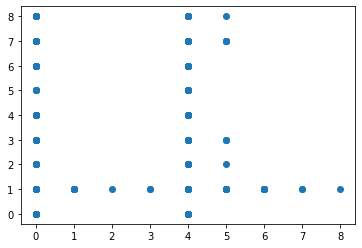

In [234]:
plt.scatter(kmeans.labels_, data[2])

In [200]:
import umap
reducer = umap.UMAP(n_components=5,n_neighbors=5)

In [205]:
embedding = reducer.fit_transform(embeddings.cpu())
# embedding = reducer.fit_transform(gottem)

In [206]:
embedding = pd.DataFrame(embedding, columns = list(range(10,15)))

In [207]:
asdf = pd.concat([pd.DataFrame(embedding), pd.DataFrame(data[2])], axis = 1)

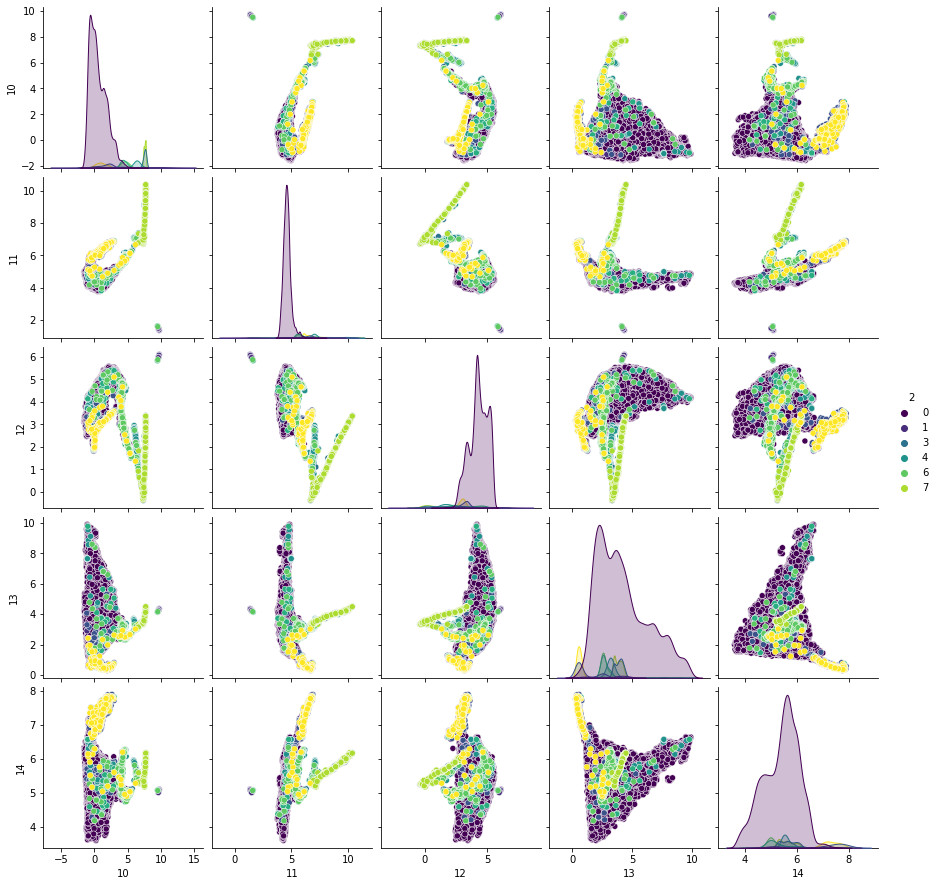

In [208]:
sns.pairplot(asdf, hue = 2, palette="viridis")

In [225]:

# Cell
def plot_manifold_3d(data, s, alpha, c, title, title_color = 'black'):

    fig, axs = plt.subplots(1,1, figsize = (15,10))
    axs.set_axis_off()

    selected_points = list(range(data.shape[0]))
    x = data[:, 0][selected_points]
    y = data[:, 1][selected_points]
    z = data[:, 2][selected_points]

    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(x, y, z, s=s,c = c, alpha=alpha, marker='.',vmin=0,vmax=np.pi, cmap = 'Set1')
    ax.set_xlabel(r'$\phi_1$', fontsize = 90)
    ax.set_ylabel(r'$\phi_2$', fontsize = 90)
    ax.set_zlabel(r'$\phi_3$', fontsize = 90)
    ax.set_title(title, fontsize = 150, color = title_color)

    xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
    xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
    ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
    ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
    zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
    zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))

    #ax.set_xticks([xmin, xmax])
    #ax.set_yticks([ymin, ymax])
    #ax.set_zticks([zmin, zmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    #ax.tick_params(labelsize=30)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)


<ipython-input-225-da203baf7bcb>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
<ipython-input-225-da203baf7bcb>:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xmax = np.float(np.format_float_positional(data[:, 0][selected_p

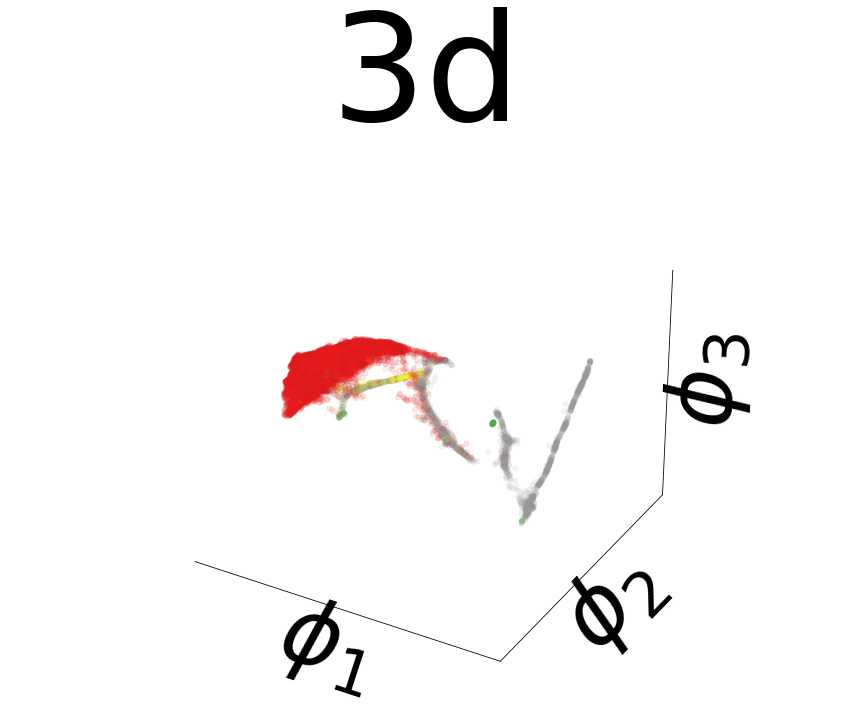

In [229]:
plot_manifold_3d(np.asarray(embedding)[:], s = 100, alpha = .1, c = np.asarray(data[2][:], dtype = int), title='3d')

In [219]:
data[2]

0        0
1        0
2        0
3        0
4        0
        ..
15729    8
15730    8
15731    8
15732    8
15733    8
Name: 2, Length: 15734, dtype: int64

In [145]:
from collections import OrderedDict

In [157]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [176]:
asdf = pd.concat([pd.DataFrame(embedding), pd.DataFrame(data[2])], axis = 1)

<AxesSubplot:xlabel='0', ylabel='1'>

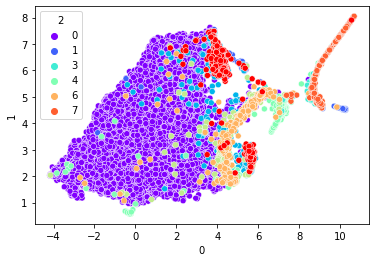

In [179]:
sns.scatterplot(asdf, x = 0, y = 1, hue = 2, palette='rainbow')

In [181]:
Counter(data[2])

Counter({0: 13097,
         1: 103,
         2: 361,
         4: 362,
         3: 363,
         5: 362,
         6: 362,
         7: 362,
         8: 362})

No handles with labels found to put in legend.


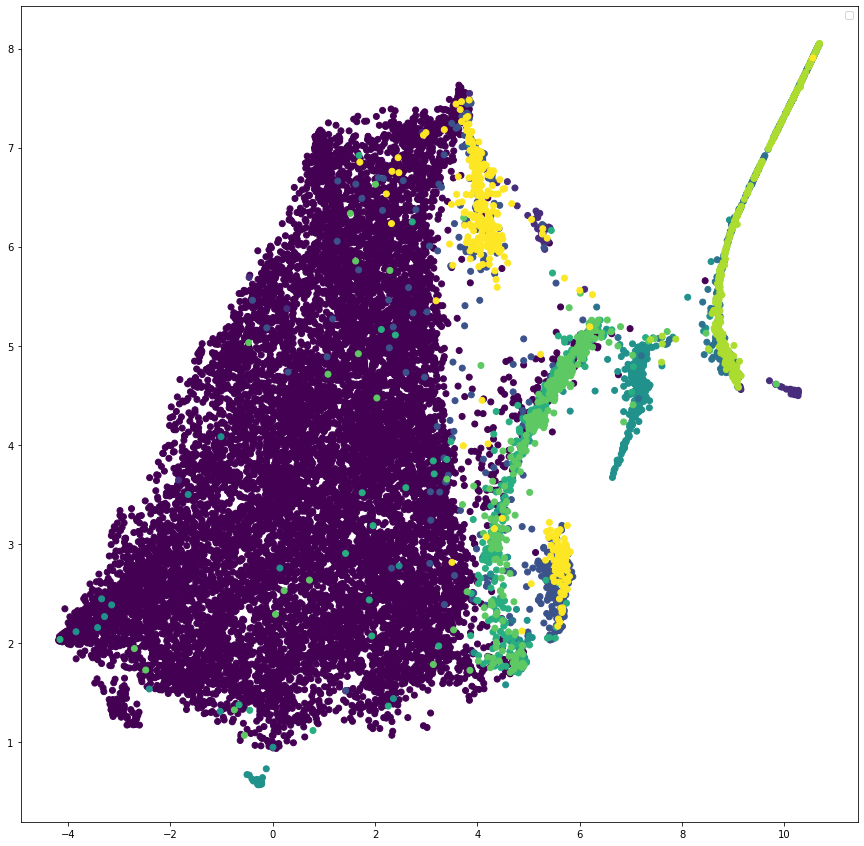

In [164]:
fig , ax = plt.subplots(1,1,figsize = (15,15))
ax.scatter(np.asarray(embedding[:,0]), np.asarray(embedding[:,1]), c = np.asarray(data[2]))
ax.legend()
# cbar = plt.colorbar()
# cbar.set_label('Color')
# handles, labels = ax.get_legend_handles_labels()
# legend_without_duplicate_labels(ax)
# by_label = OrderedDict(zip(labels, handles))
# fig.subplots_adjust(right=0.85)
# leg_ax = fig.add_axes([.9, 0.15, 0.05, 0.7])
# leg_ax.axis('off')
# leg = leg_ax.legend(by_label.values(), list(range(8)), prop={'size': 600 })
# for l in leg.get_lines():
#     l.set_alpha(1)

No handles with labels found to put in legend.


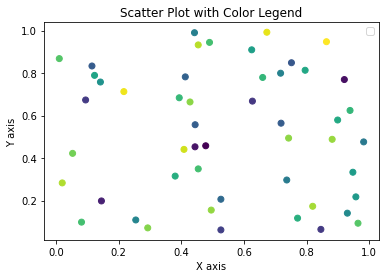

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# generate random data
x = np.random.rand(50)
y = np.random.rand(50)
colors = np.random.rand(50)

# create scatter plot with color legend
plt.scatter(x, y, c=colors, cmap='viridis')
cbar = plt.g()
cbar.set_label('Color')

# set axis labels and title
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Scatter Plot with Color Legend')

# show plot
plt.show()

In [189]:
t_svd.explained_variance_

array([4.8188357 , 9.423921  , 1.7142164 , 1.0771757 , 0.92862064,
       0.62323755, 0.57428265, 0.4491034 , 0.44443125, 0.3407371 ,
       0.3261183 , 0.31684965, 0.25875744, 0.24139316, 0.21670486,
       0.17989644, 0.16613331, 0.16062741, 0.15487778, 0.13513283,
       0.13251983, 0.12677372, 0.12106958, 0.11471584, 0.111401  ,
       0.09869859, 0.0966986 , 0.09251408, 0.09080873, 0.08469591,
       0.07827199, 0.07490391, 0.07425639, 0.07220816, 0.07124168,
       0.06843874, 0.06583776, 0.06326014, 0.06149625, 0.06085592,
       0.05917929, 0.05659491, 0.05523351, 0.05312428, 0.0524554 ,
       0.04950972, 0.04829568, 0.046973  , 0.04532549, 0.04413533],
      dtype=float32)

In [188]:
from sklearn.decomposition import TruncatedSVD
t_svd = TruncatedSVD(n_components=50)
gottem = t_svd.fit_transform(embeddings.cpu().numpy())

In [116]:
gottem = pd.DataFrame(gottem, columns = list(range(10,15)))

In [118]:
combo = pd.concat([gottem,data[2]] , axis = 1)

In [126]:
from collections import Counter
Counter(combo[2])

Counter({0: 13097,
         1: 103,
         2: 361,
         4: 362,
         3: 363,
         5: 362,
         6: 362,
         7: 362,
         8: 362})

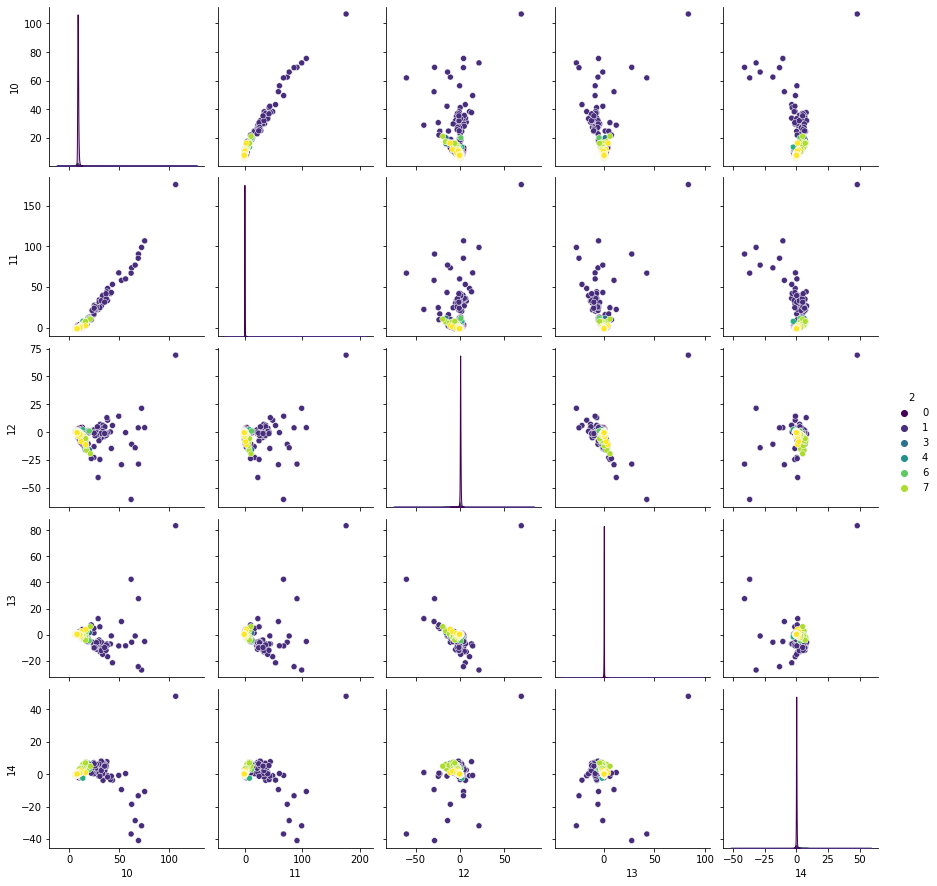

In [123]:
sns.pairplot(combo, hue = 2, palette="viridis")

In [68]:
data[2]

0        0
1        0
2        0
3        0
4        0
        ..
15729    8
15730    8
15731    8
15732    8
15733    8
Name: 2, Length: 15734, dtype: int64

In [55]:
import seaborn as sns

In [62]:
gottem.shape

(15734, 10)

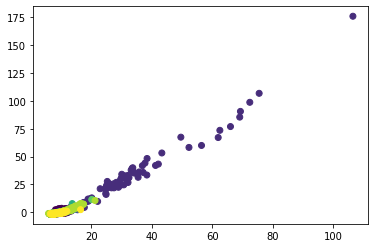

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.scatter(gottem[:,0], gottem[:,1], c= data[2])

In [15]:
[model(audio_data).unsqueeze(-1) for audio_data in audio_datas]

AttributeError: 'numpy.ndarray' object has no attribute 'squeeze_'